# Perkenalan

Nama : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

Data set overview :

Objective : 

# Import Libraries

In [1]:
# Data Loading
import os
import glob
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Data Preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

import tensorflow as tf
print('Tensorflow version', tf.__version__)


Tensorflow version 2.10.0


# Data Loading

In [2]:
# Download the data set
!kaggle datasets download chrisfilo/fruit-recognition

fruit-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Unzip the data set
# -q = quiet mode
# -n never overwrite existing files
# -o overwrite fies WITHOUT prompting
# -d exdir
!unzip -q -n fruit-recognition.zip -d ./data

In [4]:
# Get kind of fruits
print(os.listdir('./data/'))

['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes']


In [5]:
# Get Apple sub-categories
# folder 'Total Number of Apples' is similar to folder '
print(os.listdir('./data/Apple/'))

['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F', 'Total Number of Apples']


In [6]:
# Get Apple images
print(os.listdir('./data/Apple/Apple A')[:5])
# Get Banana images
print(os.listdir('./data/Banana/')[:5])

['Apple 1.png', 'Apple 10.png', 'Apple 100.png', 'Apple 101.png', 'Apple 102.png']
['71Banana02034.png', '79Banana02063.png', '87Banana02109.png', 'Banana01.png', 'Banana010.png']


In [7]:
# Get kind of fruits and its sub-categories
def print_kinds():
    kinds = os.listdir('./data/')
    print("kinds", kinds)
    for kind in kinds:
        sub_categories = [path for path in os.listdir('./data/'+kind) 
                          if os.path.isdir('./data/'+kind+'/'+path)]
        if len(sub_categories) != 0:
            print("sub-categories of", kind, sub_categories)
    
print_kinds()

kinds ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes']
sub-categories of Apple ['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F', 'Total Number of Apples']
sub-categories of Guava ['guava A', 'guava B', 'Guava total', 'guava total final']
sub-categories of Kiwi ['kiwi A', 'Kiwi B', 'Kiwi C', 'Total Number of Kiwi fruit']


TODO
- [ ] Do EDA on Apple, Guava, Kiwi sub-categories.

In [8]:
# Load the data set
def isolate():
    global df
    
    data = []
    
    kinds = os.listdir('./data/')
    for kind in kinds:
        sub_categories = [path for path in os.listdir(f'./data/{kind}')
                          if os.path.isdir(f'./data/{kind}/{path}')]
        # ./data/Apple/Apple A -> sub_categories = ['Apple A']
        # ./data/Banana/71Banana02034.png -> sub_categories = []
        for sub_category in sub_categories:
            data += [[sub_category, path] for path in 
                     glob.glob(pathname=f'./data/{kind}/{sub_category}/*.png')]
            continue
        
        data += [[kind, path] for path in glob.glob(pathname=f'./data/{kind}/*.png')]
            
    df = pd.DataFrame(data=data, columns=['kind', 'path'])
    
isolate()

In [9]:
# Preview the data set
df.head()

,kind,path
0,Apple A,./data/Apple/Apple A/Apple 1.png
1,Apple A,./data/Apple/Apple A/Apple 10.png
2,Apple A,./data/Apple/Apple A/Apple 100.png
3,Apple A,./data/Apple/Apple A/Apple 101.png
4,Apple A,./data/Apple/Apple A/Apple 102.png


# Functions

In [10]:
# visualize each sub categories with 3 samples.
def imshow_kind(data=df, kind='Apple'):
    samples = data[data['kind'].str.contains(kind, case=False)] \
        .groupby(by='kind').sample(3, random_state=None)
    
    fig, axes = plt.subplots(
        nrows=len(samples['kind'].unique()), ncols=3, figsize=(10,10), 
        layout='constrained')
    for (_, sample), ax in zip(samples.iterrows(), axes.ravel()):
        img = mpimg.imread(sample['path'])
        ax.imshow(img)
        ax.set_title("/".join(sample['path'].split('/')[-2:]))

# Exploratory Data Analysis

In [11]:
# Duplicate the data set
df_a = df.copy()

## Apple sub-categories

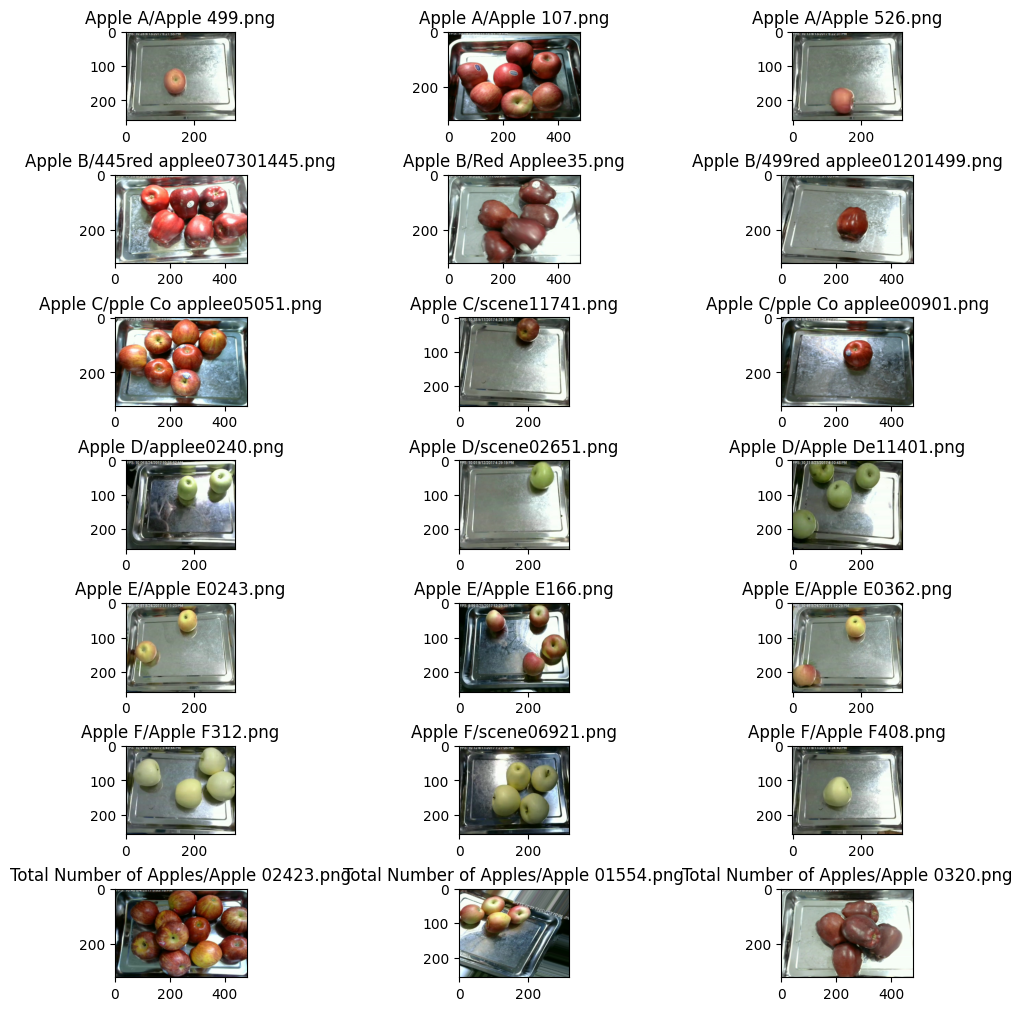

In [12]:
imshow_kind(data=df_a, kind='Apple')

IMPORTANT
- Do not use folder 'Total Number of Apples' to train

  The folder contains mutiple sub-categories of Apple.

In [13]:
# drop kind 'Total Number of Apples'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Apples'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Guava sub-categories

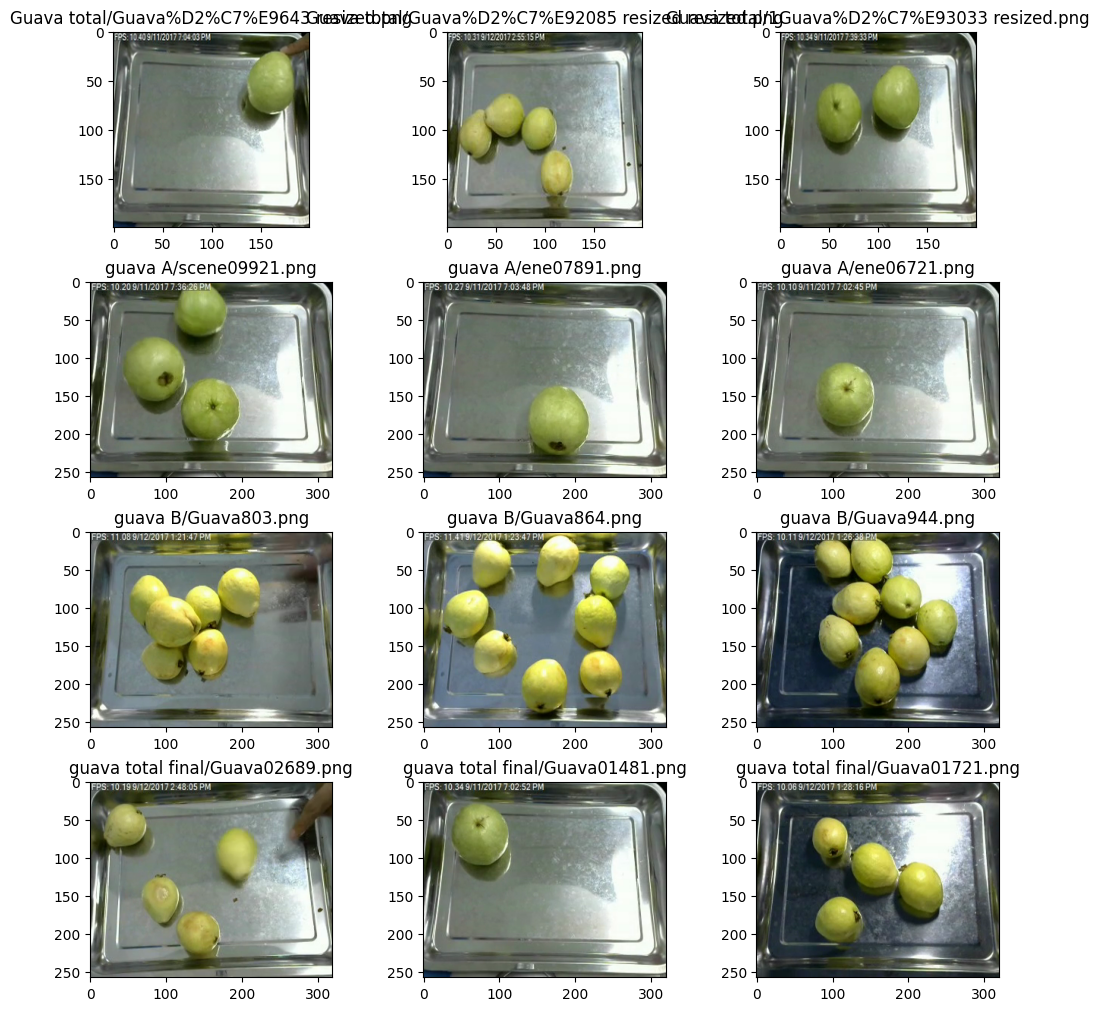

In [14]:
imshow_kind(data=df_a, kind='Guava')

IMPORTANT
- Do not use folder 'Guava total' and 'Guava total final'
  
  We can't distinguish folder 'Guava total' and 'guava total final'

In [15]:
# Drop kind 'Guava total', 'guava total final'
def isolate():
    indicies = df_a[df_a['kind'].isin(['Guava total', 'guava total final'])].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Kiwi sub-categories

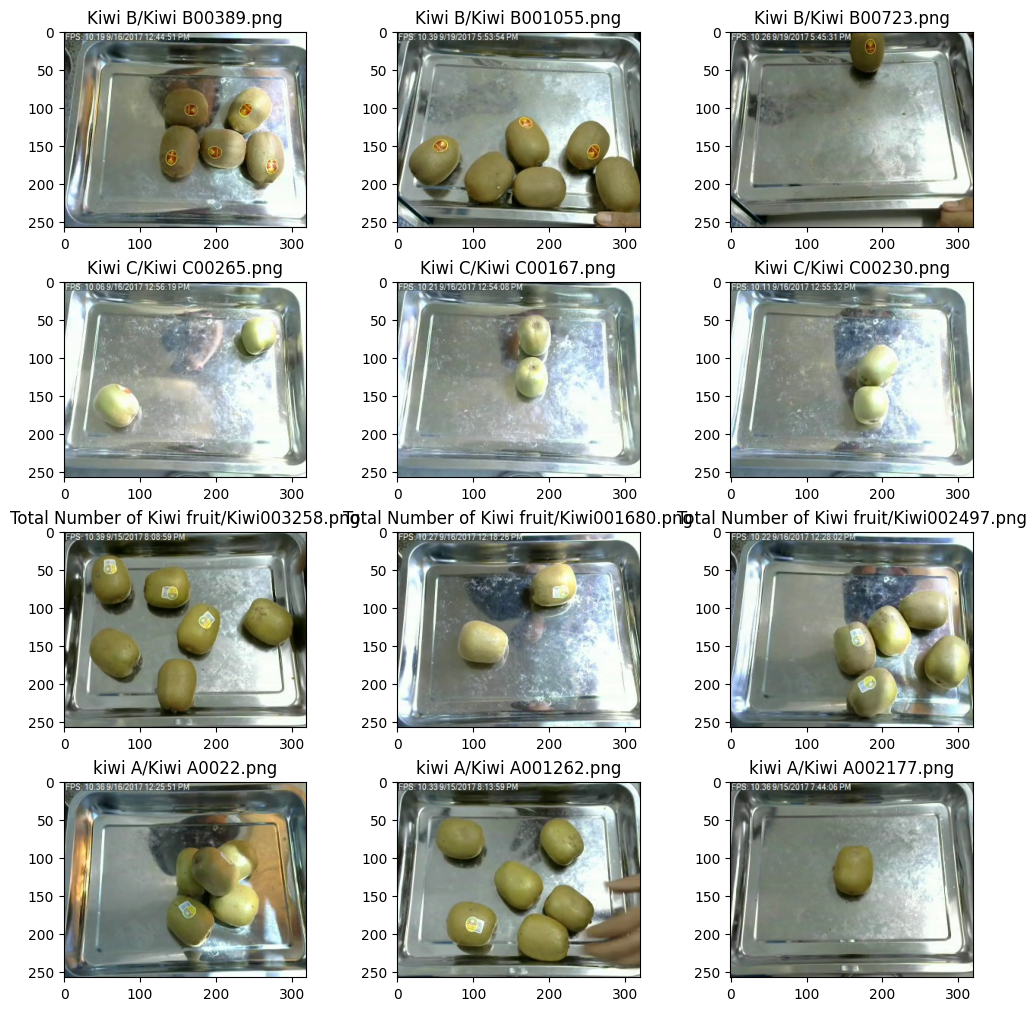

In [16]:
imshow_kind(data=df_a, kind='Kiwi')

IMPORTANT
- Do not use folder 'Total Number of Kiwi fruit'

  The folder contains multiple sub-categories of Kiwi.

In [17]:
# drop kind 'Total Number of Kiwi fruit'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Kiwi fruit'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Class Proportion

<AxesSubplot: xlabel='kind', ylabel='count'>

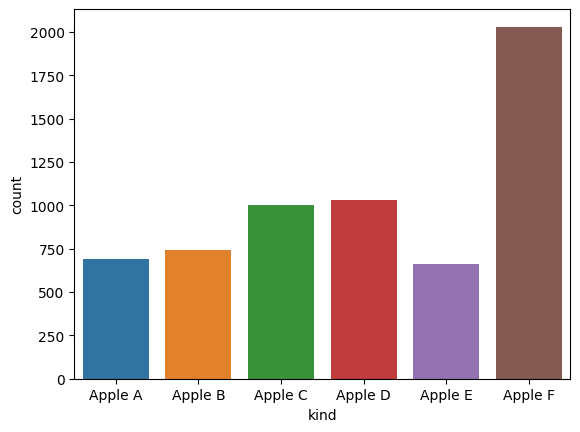

In [18]:
# Check histogram of Apple
sns.countplot(data=df_a[df_a['kind'].str.contains('Apple', case=False)], x='kind')

<AxesSubplot: xlabel='kind', ylabel='count'>

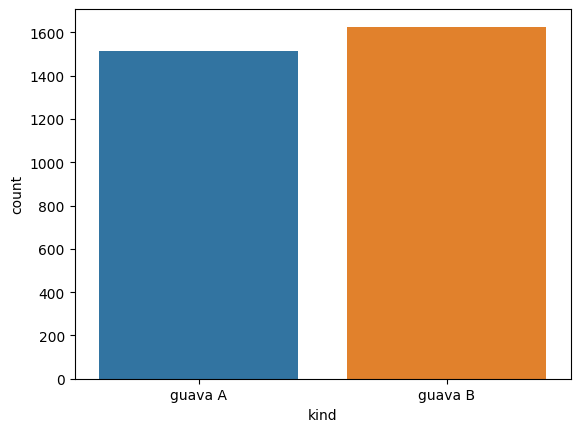

In [19]:
# Check histogram of Guava
sns.countplot(data=df_a[df_a['kind'].str.contains('Guava', case=False)], x='kind')

<AxesSubplot: xlabel='kind', ylabel='count'>

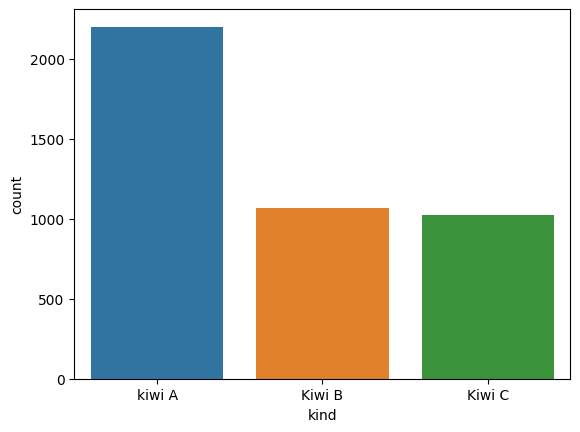

In [20]:
# Check histogram of Kiwi
sns.countplot(data=df_a[df_a['kind'].str.contains('Kiwi', case=False)], x='kind')

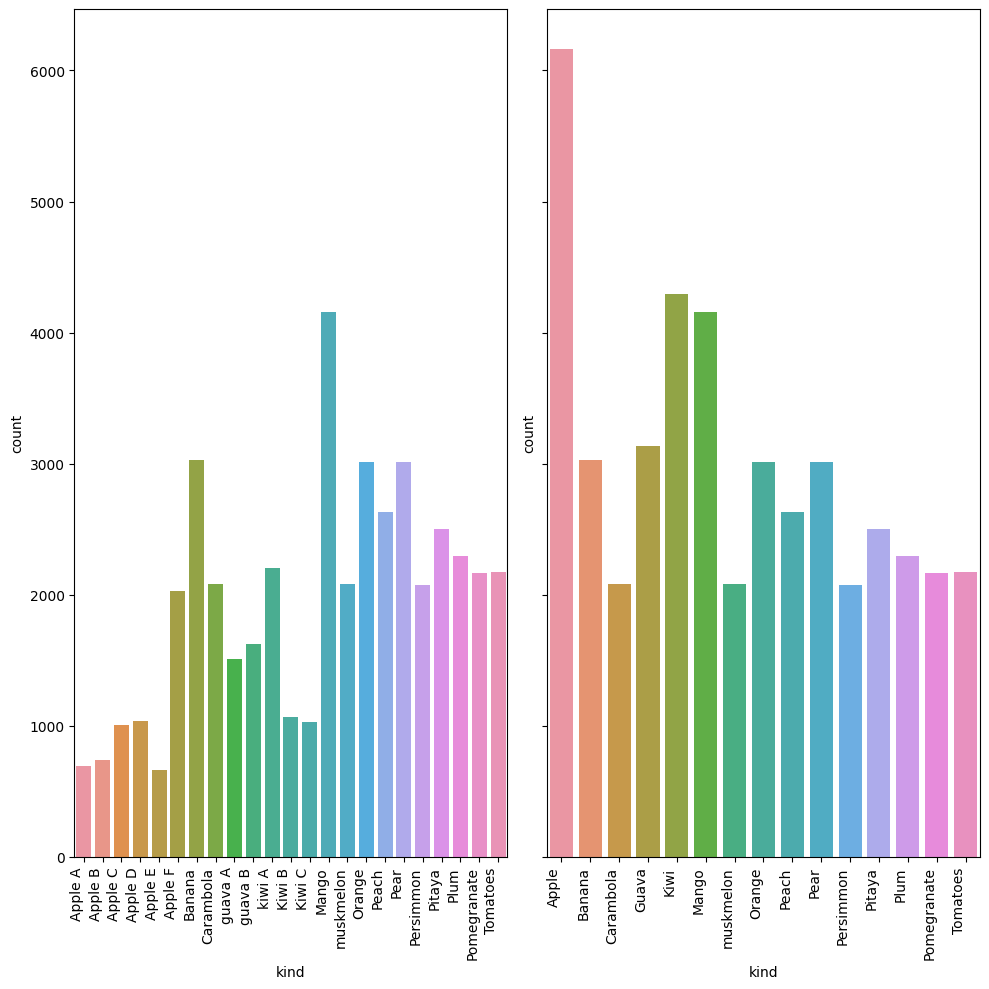

In [21]:
# Check histogram of kinds with sub-categories and without sub-categories
def isolate():    
    fig, axes = plt.subplots(1,2, figsize=(10,10), sharey=True)
    
    sns.countplot(data=df_a, x='kind', ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right')
    plt.tight_layout()
    
    df_c = df_a.copy()
    
    df_c.loc[df_c['kind'].str.contains("Apple", case=False), 'kind'] = 'Apple'
    df_c.loc[df_c['kind'].str.contains('Guava', case=False), 'kind'] = 'Guava'
    df_c.loc[df_c['kind'].str.contains('Kiwi', case=False), 'kind'] = 'Kiwi'
    
    sns.countplot(data=df_c, x='kind')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')
    plt.tight_layout()
    
isolate()

UNCERTAIN

- Our understanding of how Convolutional Neural Networks works is by filtering pixels with a kernel. 

  The kernel does 3 things:
  1. Make the pixels smaller while also make sure that the model can still classify the image if the image was to be shifted or rotated.
  2. Help the model to classify image based on correlation (because the kernel makes a feature map and each cell in the feature map corresponds to a group of neighboring pixels)

We are not sure whether imbalanced data set will makes the model less sensitive to the class minority.

Few things to be sure:
1. we believe each Apple's sub category should have its own label as it is common for different kind of Apple to have different price in a grocery store.
2. Imbalanced data affects the ANN. By a glance, CNN should be affected by imbalanced data as well as it uses the same concept of weight, bias, optimizer, kernel initializer.

TODO
- [ ] Balanced the data set with under sampling.

      Get Apple E value_counts(), we will do this split strategy:
      1. data set  -> train_val 0.8 + test 0.2
      2. train_val -> train 0.8 + val 0.2
      
      therefore the data set proportion are: train 0.64 + val 0.16 + test 0.2

In [22]:
# Get Apple E value_counts()
df_a.loc[df_a['kind'] == 'Apple E', 'kind'].value_counts()

Apple E    664
Name: kind, dtype: int64

In [23]:
# Balanced data set with under sampling
df_b = df_a.copy()
df_b = df_b.groupby(by='kind').sample(n=664, random_state=0)

## Rescaling Effect

According to kode.id, [0-255] range is not ideal for neural network. Therefore, we are going to rescale it to [0-1] range

tf.Tensor([79 84 82], shape=(3,), dtype=uint8)
tf.Tensor([0.30980393 0.32941177 0.32156864], shape=(3,), dtype=float32)


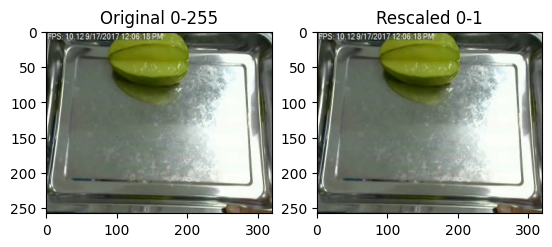

In [114]:
# See rescaling effect
def isolate():
    raw = tf.io.read_file(df_a.sample(n=1).iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(img)
    axes[0].set_title('Original 0-255')
    
    rescale = tf.keras.layers.Rescaling(1./255)
    axes[1].imshow(rescale(img))
    axes[1].set_title('Rescaled 0-1')
    
    print(img[0,0])
    print(rescale(img)[0,0])
    
isolate()

## Resize Effect

The image should had resolution of 320x258 pixels. However, we found some images with 480x322 pixels. The model expects a fixed `input_shape`. Therefore, we will resize it

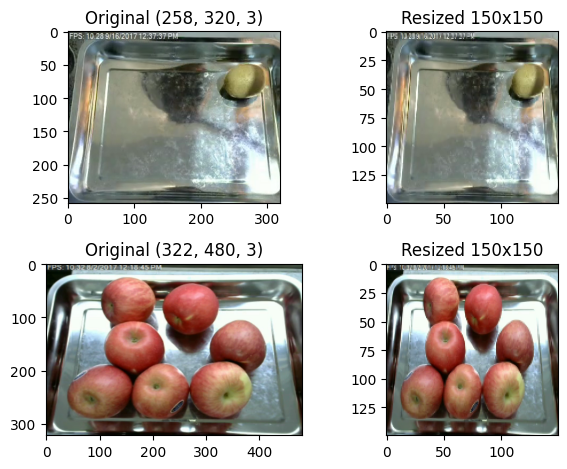

In [118]:
# visualize resize effect
def isolate():
    fig, axes = plt.subplots(2,2)
    
    raw = tf.io.read_file(df_a.sample(n=1).iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    axes[0][0].imshow(img)
    axes[0][0].set_title(f'Original {img.shape}')
    
    resize = tf.keras.Sequential([
        tf.keras.layers.Resizing(150,150),
        # the Resizing output is integers. But it won't
        tf.keras.layers.Rescaling(1./255)
    ])
    
    axes[0][1].imshow(resize(img))
    axes[0][1].set_title('Resized 150x150')
    
    raw = tf.io.read_file(df_a.iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    axes[1][0].imshow(img)
    axes[1][0].set_title(f'Original {img.shape}')
    
    axes[1][1].imshow(resize(img))
    axes[1][1].set_title('Resized 150x150')
    
    plt.tight_layout()
    
isolate()

# Data Preprocessing

In [25]:
# Split data set to train, val, test
# Keras have validation_split parameter which makes spliting the data set convenient
# Although Keras told us it will select the last % percentage as test set 
# (meaning we know which data that will be used as the validation set)
# However, we can't stratify it.
df_train_val, df_test = train_test_split(df_b, test_size=0.2, random_state=0, stratify=df_b['kind'])
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=0, stratify=df_train_val['kind'])

ASK INSTRUCTOR

- [ ] Does stratify helps in CNN?
- [ ] Does stratify cause bias?
      
      My assumption is:
      1. The model now expects the class weights to be equal. What if the entire test set does not have fruit 'Apple A'? Will the model tend to classify some images as 'Apple A'? Which resulted in mislabeling?

# Model Definition

The resized pixels are 150x150. 
1. Therefore, the `Flatten()` output should be lower than 150x150.
2. Or if we want to imagine CNN as random forest, the `Flatten()` output can be higher than 150x150.

ASK INSTRUCTOR

- [ ] Is `Conv2D(filters=1)` worse than `Conv2D(filters=16)`?

  My current assumption is that the use of CNN is to reduce the number of inputs to the neural network using the kernel.

  Changing `Conv2D(filters=16)` defeat that purpose.

[reference filters](https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo)

[reference edges in 3d shape](https://opjsrgh.in/Content/Worksheet/PRACTICE-WS/day93/3-MATHS.pdf)

[reference CNN fruits](https://www.semanticscholar.org/paper/Convolutional-Neural-Networks-(CNN)-for-Detecting-Risdin-Mondal/8352826ff8f12ded684bf07540341a5ef6da06fd)

In [26]:
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(monitor='val_loss', 
                  patience=20, min_delta=0.0001,
                  mode='min',
                  restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                      # We believe RreduceLROnPlateau should have less patience than
                      # EarlyStopping
                      patience=10, min_delta=0.0001,
                      min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger('./results/train.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath="seq_1.h5", monitor='val_loss', save_best_only=True)
]

seq_1 = Sequential()

img_shape = (150, 150, 3)

# we are not sure how more filters help to classify image
# but we imagine a 3d shape to have 
seq_1.add(Conv2D(
    filters=3, kernel_size=(3,3), activation='relu', input_shape=img_shape,
    use_bias=True))

# pool_size=(2,2), strides=2
# so it does not overlap itself.
seq_1.add(MaxPooling2D(pool_size=(2,2), strides=2))

seq_1.add(Flatten())

seq_1.add(Dense(units=1))

seq_1.add(Dense(units=len(df_a['kind'].unique()), activation='relu'))

seq_1.add(Activation(activation='softmax'))

seq_1.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16428)             0         
                                                                 
 dense (Dense)               (None, 1)                 16429     
                                                                 
 dense_1 (Dense)             (None, 23)                46        
                                                                 
 activation (Activation)     (None, 23)      

2022-12-10 10:57:56.299363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 10:57:56.299477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
